# Quantum Maze Solver

In [4]:
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.circuit.library import GroverOperator
from maze_oracle import MazeOracle
import sys
sys.path.insert(1, '../')
from utils import Helpers as hp


In [5]:
Edge = tuple[int, int]

class Path(list[int]):
    def __init__(self, l: list[Edge]):
        super().__init__()
        if len(l) > 0:
            self.append(l[0][0])
        for e in l:
            self.append(e[1])

    def remove_cycles(self) -> 'Path':
        p = Path([])
        count = set()
        for x in self:
            if x in count:
                g = p.pop()
                while g != x:
                    count.discard(g)
                    g = p.pop()
            p.append(x)
            count.add(x)
        return p

    def __repr__(self):
        if len(self) > 0:
            s = [repr(e) for e in self]
            return '[' + str.join(' -> ', s) + ']'
        else:
            return '[]'
    def __hash__(self):
        return hash(repr(self))

class Maze:
    def __init__(self, num_nodes: int, edges: list[Edge], first_node: int, last_node: int, directed: bool = False):
        self.num_nodes = num_nodes
        self.first_node = first_node
        self.last_node = last_node
        self.edges = edges
        self.directed = directed
        self.max_path_length = num_nodes - 1

class QuantumMazeCircuit(Maze, QuantumCircuit):
    def __init__(self, from_maze: Maze):
        self.node_bits_size = int(np.ceil( np.log2(from_maze.num_nodes) ))
        self.num_qubit_in_path = (from_maze.max_path_length + 1) * self.node_bits_size
        num_ancillas = from_maze.max_path_length * 2 - 1
        self.total_size = self.num_qubit_in_path + num_ancillas

        Maze.__init__(self, from_maze.num_nodes, from_maze.edges, from_maze.first_node, from_maze.last_node, from_maze.directed)
        QuantumCircuit.__init__(self, self.total_size, self.num_qubit_in_path)

class QuantumMazeSolver:
    def generate_circuit(self, maze: Maze) -> QuantumMazeCircuit:
        ### Setup
        circ = QuantumMazeCircuit(maze)
        circ.name = 'Maze Solver'
        # Get oracle
        oracle = MazeOracleGenerator(circ.num_nodes, circ.max_path_length, circ.directed).add_edges(circ.edges).set_first_node(circ.first_node).set_last_node(circ.last_node).generate()
        # Get grover's diffuser
        diffuser = GroverOperator(QuantumCircuit(circ.num_qubit_in_path))
        # Compute repetition time
        iterations = int(np.ceil( (np.pi / 4) * np.sqrt(circ.num_qubit_in_path) ))

        ### Build
        # Make superpositions
        for i in range(circ.num_qubit_in_path):
            circ.h(i)
        # Repeat grover operation
        # for i in range(iterations):
        for i in range(iterations):
            circ.barrier()
            circ.append(oracle, range(circ.total_size))             # Apply oracle
            circ.append(diffuser, range(circ.num_qubit_in_path))    # Apply diffuser

        return circ

    def __result_to_path(self, result: str, path_length: int, node_size: int) -> Path:
        path = []
        for i in range(path_length):
            offset = i*node_size
            n2 = int(result[offset : offset+node_size], 2)
            n1 = int(result[offset+node_size : offset+ 2*node_size], 2)
            path.insert(0, (n1, n2))
        return Path(path)

    def run(self, circuit: QuantumMazeCircuit, shots: int = 1) -> list[Path]:
        sim = AerSimulator()
        transpiled = transpile(circuit, sim)
        # Add measure to circuit
        transpiled.measure(range(circuit.num_qubit_in_path), range(circuit.num_qubit_in_path))
        # Run
        results = sim.run(transpiled, shots=shots, memory=True).result().get_memory()
        paths = [self.__result_to_path(r, circuit.max_path_length, circuit.node_bits_size) for r in results]
        return paths

    def solve(self, maze: Maze) -> Path:
        maze_circ = self.generate_circuit(maze)
        path = self.run(maze_circ, shots=1)
        return path[0]

### Tests

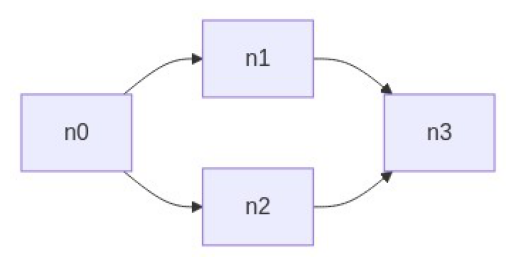

In [6]:
hp.mm("""
flowchart LR;
    n0 --> n1;
    n0 --> n2;
    n1 --> n3;
    n2 --> n3;
""")

edges = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3),
]

In [7]:
# oracle = MazeOracleGenerator(5).add_edges(edges).set_first_node(0).set_last_node(5).generate()
# display(oracle.decompose(reps=1).draw('mpl'))

maze = Maze(4, edges, first_node=0, last_node=3, directed=False)
solver = QuantumMazeSolver()
print('Maze:')

Maze:


In [8]:
qc = solver.generate_circuit(maze)
qc.draw('mpl')

NameError: name 'MazeOracleGenerator' is not defined

In [ ]:
import os
import sys
sys.path.insert(0, os.path.abspath('utils'))
from qiskit.quantum_info import Statevector
sys.path.insert(1, '../')
from utils import Helpers as hp


s = Statevector.from_label('00000000000')
hp.plot_statevector(s.evolve(qc), '')

In [ ]:
result = solver.run(qc, shots=10000)
from collections import Counter
r = [print(k.remove_cycles(), ':', v) for k, v in sorted(Counter(result).items(), key=lambda x: -x[1])]

[0 -> 1 -> 2 -> 3] : 1808
[1 -> 3] : 53
[2] : 45
[3] : 45
[2] : 45
[1 -> 2] : 45
[1 -> 0 -> 3] : 44
[0 -> 1] : 44
[0 -> 1] : 43
[0 -> 3 -> 2] : 43
[3 -> 0 -> 1] : 43
[2 -> 3] : 42
[0 -> 3 -> 1 -> 2] : 42
[0 -> 1 -> 2] : 42
[1] : 42
[3 -> 1 -> 2] : 41
[0] : 41
[1 -> 2 -> 3 -> 0] : 41
[0 -> 2] : 41
[1 -> 0 -> 3 -> 2] : 40
[3 -> 1] : 40
[3 -> 0] : 40
[1 -> 3] : 40
[2 -> 1] : 40
[2] : 40
[3 -> 2] : 39
[3 -> 1 -> 0] : 39
[2 -> 0 -> 3 -> 1] : 39
[2] : 39
[2 -> 1 -> 3] : 39
[3 -> 0 -> 2] : 39
[3 -> 2 -> 1] : 39
[1] : 38
[2 -> 0] : 38
[1 -> 2] : 38
[1] : 38
[0 -> 1 -> 2] : 38
[3 -> 2] : 38
[3 -> 1] : 38
[3 -> 0 -> 2 -> 1] : 38
[3] : 38
[1 -> 0] : 38
[3 -> 1 -> 0] : 38
[0 -> 3] : 37
[2 -> 0 -> 1 -> 3] : 37
[3 -> 2 -> 0] : 37
[1] : 37
[2 -> 3] : 37
[1] : 37
[2 -> 0] : 37
[3] : 37
[0 -> 3] : 37
[2 -> 1 -> 3 -> 0] : 37
[3 -> 0 -> 2] : 36
[0 -> 2 -> 3] : 36
[3 -> 1] : 36
[2 -> 0] : 36
[0] : 36
[1 -> 0 -> 2 -> 3] : 36
[1] : 36
[3 -> 0] : 36
[2 -> 1 -> 3] : 36
[1 -> 0 -> 3] : 36
[2] : 36
[3 -> 2] : 3